# Intraday Liquidity Reporting

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.9.9-blue">

This notebook is a small preview of what we can do with [Atoti](https://www.atoti.io/) for intraday liquidity monitoring based on [BCBS248](https://www.bis.org/publ/bcbs248.pdf):

* Daily maximum intraday liquidity usage
* Largest positive and negative net cumulative positions
* Gross payment sent and received

With that, we can easily derive the monthly reporting:  

<img src="http://data.atoti.io/notebooks/intraday-liquidity/img/monthly_reporting.png" width="850px" />

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=intraday_liquidity" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
import random
import time
import atoti as tt
import pandas as pd

## 1. Getting started

The general outline to [getting started with Atoti](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Getting-started) is as follows:
1. Instantiate an [Atoti session](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session)
2. Create [Atoti table(s)](https://docs.atoti.io/latest/lib/atoti/atoti.table.html)
3. [Join the Atoti tables](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Enriching-the-cube) as necessary
4. [Create Atoti cube](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube)
5. Proceed with [hierarchy manipulations](https://docs.atoti.io/latest/lib/atoti/atoti.hierarchies.html), [measure creation](https://docs.atoti.io/latest/lib/atoti/atoti.measure.html) and visualization.

Interwined with the business use case, we will show some tips on how to customize the solution.

### 1.1 Instantiate Atoti session

We can easily instantiate [Atoti session](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session) without any parameters. However, in our use case, we have fixed the `port` for the web application and also persist our dashboards in the content folder as configured with the `user_content_storage` parameter.  

Here, we zoom in on the parameter `java_options` to see how we can customize the memory usage for the instance. The JVM default memory is set to use 25% of the machine memory.  
We used `-XX:MaxRAMPercentage` to dedicate 50% of the resources to the Java Heap. Check out the [_Deployment setup_](https://docs.atoti.io/latest/deployment/deployment_setup.html) guide in [Atoti documentation](https://docs.atoti.io/) to find out more.

In [2]:
session = tt.Session.start(
    tt.SessionConfig(
        port=10012,
        user_content_storage="./content",
        java_options=["-XX:MaxRAMPercentage=50", "-XX:+UnlockExperimentalVMOptions"],
    )
)

Access the web application from the link below. It's running on the port defined for the session above.  
Bear in mind that we have yet to create any cubes for the session. Hence, there's nothing we can do on the web application yet. We will come back to this later on.

In [3]:
session.link

http://localhost:10012

### 1.2 Create Atoti tables  

There are two ways we can create Atoti tables:
1. Use [`atoti.Session.create_table`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_table) 
2. Use the `atoti.Session.read_*` functions where `*` depends on the type of data sources. E.g. we will use [`atoti.Session.read_csv`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.read_csv) to read `CSV` files and [`atoti.Session.read_parquet`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.read_parquet) to read parquet files.  

<strong>Differences between `create_table` and `read_*`</strong>

Using `create_table`, we will have to define the table structure all the way to the data type of the columns.  
In addition, the created table is empty. We will use the `atoti.Table.load_*` functions such as [`load_csv`](https://docs.atoti.io/latest/lib/atoti/atoti.table.html#atoti.Table.load_csv) to load data into the table.  

`read_*` functions creates the table based on the data source structure and loads the data.  
Data type is inferred for CSV types and inherited from Python objects such as Pandas DataFrame and the metadata of Parquet files.  

#### 1.2.1 Payment cashflows

We have created some mock cashflows for the month of September 2021 and some days in October 2021.  
Based on the direction of the cashflow, we know if it's payment sent or received:
- IN: Payment received
- OUT: Payment sent

For each day, we will receive the opening balance at the time 00:00:00 for each account, identified by the status _Open party_ or _Open posn_.

In [4]:
payment_tbl = session.read_parquet(
    "s3://data.atoti.io/notebooks/intraday-liquidity/data/cashflow_202110_counterparty.parquet",
    table_name="Cashflows",
    keys=["Transaction_Id", "Transaction_Date", "Settlement_Date"],
)
payment_tbl.head()

,,,Legal_Entity,Country,Correspondent_Name,Correspondent_Account,Counterparty,Settlement_Currency,Settlement_Time,Status,Direction,Settlement_Amount,Net_Settlement_Amount,Opening_Balance,Available,Expected,Processing,Anticipated,Collateral,Outlook_Amount,Forecast_Amount
Transaction_Id,Transaction_Date,Settlement_Date,,,,,,,,,,,,,,,,,,,
TXN2021090101391563A1,2021-09-01,2021-09-01,AU_BRANCH,UNITED STATES,"J.P Morgan Chase Bank, New York",987777175,Argenta,USD,00:00:00,Open posn,IN,1741638.01,1741638.01,1741638.01,1741638.01,<NA>,<NA>,<NA>,<NA>,1741638.01,1741638.01
TXN2021090101391591A1,2021-09-01,2021-09-01,AU_BRANCH,UNITED KINGDOM,"Barclays Bank PLC, London",20325555629413,Julius Baer Group,GBP,00:00:00,Open posn,IN,1367205.47,1367205.47,1367205.47,1367205.47,<NA>,<NA>,<NA>,<NA>,1367205.47,1367205.47
TXN2021090101391594A1,2021-09-01,2021-09-01,US_BRANCH,GERMANY,"Deutsche Bank AG, Frankfurt am Main",100 8885417 1000,Macquarie Bank,EUR,00:00:00,Open posn,IN,1463774.34,1463774.34,1463774.34,1463774.34,<NA>,<NA>,<NA>,<NA>,1463774.34,1463774.34
TXN2021090101391612A1,2021-09-01,2021-09-01,UK_PLC,UNITED KINGDOM,"Citibank NA, New York",ATOTI-0033,Sumitomo Mitsui Financial Group,GBP,00:00:00,Open party,IN,1218198.24,1218198.24,1218198.24,1218198.24,<NA>,<NA>,<NA>,<NA>,1218198.24,1218198.24
TXN2021090101391613A1,2021-09-01,2021-09-01,US_BRANCH,UNITED STATES,Account 3,RAND-0039,HSBC Hong Kong,USD,00:00:00,Open party,IN,1914110.13,1914110.13,1914110.13,1914110.13,<NA>,<NA>,<NA>,<NA>,1914110.13,1914110.13


#### 1.2.2 Time table for bucketing

The time table consists of the time buckets that allows us to look at the cashflows at hours, minutes or seconds intervals. It's basically a permutation of 24 hours x 60 minutes x 60 seconds.

In [5]:
time_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/intraday-liquidity/data/time.csv",
    keys=["Time"],
    data_types={
        "Time": tt.type.STRING,
        "Hour": tt.type.STRING,
        "Minute": tt.type.STRING,
        "Second": tt.type.STRING,
        "Minute (ext)": tt.type.STRING,
    },
    table_name="Time",
)

time_tbl.head()

,Hour,Minute,Second,Minute (ext)
Time,,,,
00:00:03,00,:00,:03,00:00
01:20:55,01,:20,:55,01:20
01:21:04,01,:21,:04,01:21
01:21:07,01,:21,:07,01:21
00:40:36,00,:40,:36,00:40


### 1.3 Join tables  

[Joining Atoti table](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Join) is similar to how we perform table joins in databases. However, we apply [snowflake schema](https://en.wikipedia.org/wiki/Snowflake_schema) for Atoti.  
This means that we choose a base table that is most granular and we centralize other fact tables around the based table.  

In this case, our base table is the payment table. So, we perform a join from `payment_tbl.Settlement_Time` to `time_tbl.Time` by specifying the join condition.  

> Tips: Usually, we do not have to specify the conditions joining the tables unless the joining columns have different names. Atoti infers the relationship based on common column names between the tables.

In [6]:
payment_tbl.join(time_tbl, payment_tbl["Settlement_Time"] == time_tbl["Time"])

Verify the table schema below:

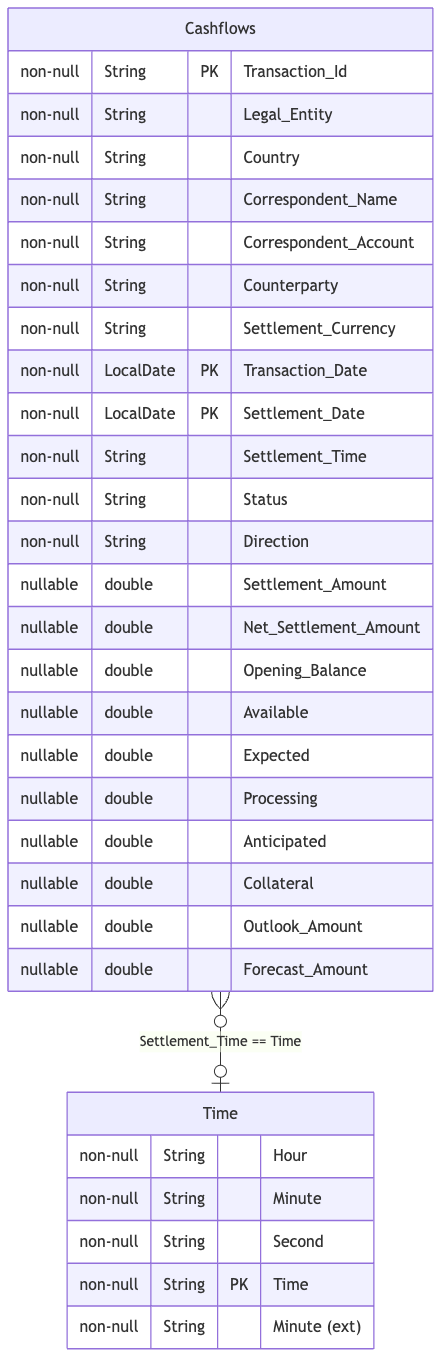

In [7]:
session.tables.schema

By joining the two tables via timestamps allows us to identify the time bucket each cashflow transaction falls under.

### 1.4 Create Atoti cube

When we create a cube in `auto` mode, Atoti creates a `mean` and a `sum` measure for each numerical columns. It's a great way to quickly explore the data and perform simple analytics.  
In this use case, to avoid cluttering of unwanted measures, we create the Atoti cube with the `no_measures` mode.  
Check the [Atoti documentation](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube) on the available modes.

In [8]:
cube = session.create_cube(payment_tbl, name="Intraday Liquidity", mode="no_measures")

> Tips: We could change the default limits set on some of the application behaviours such as `queriesTimeLimit`, `queriesResultLimit.intermediateLimit` and `queriesResultLimit.transientLimit`.  
  
  
Below we removed the restrictions on the intermediate results, which is a limit on the number of point locations for a single intermediate result.  
Check out the [shared contexts](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.shared_context).

In [9]:
cube.shared_context["queriesResultLimit.intermediateLimit"] = -1
cube.shared_context["queriesResultLimit.transientLimit"] = -1

## 2 Setting up Atoti as monitoring tool  

In this section, we look at how we can manipulate the hierarchies and craft some measures to cater to our needs.  
Before we start, let's create alias variables for the cube attributes:

In [10]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 2.1 Creating basic measures

While cube in "auto" mode can create the basic `mean` and `sum` measures by default, we will create our measures manually to keep things lean and clean.  
Let's start with the easiest type of measure - summation. We will create it recursively for all the numerical columns in the payment table. Check out other available [aggregation functions](https://docs.atoti.io/latest/lib/atoti/atoti.agg.html).

In [11]:
def create_sum_measure(col_name, tbl):
    m[col_name] = tt.where(
        ~l["Settlement_Currency"].isnull(), tt.agg.sum(tbl[col_name])
    )

We have impose a [condition](https://docs.atoti.io/latest/lib/atoti/atoti.function.where.html#atoti.where) to return the summation only when `Settlement_Currency` is available in the query.  
This is important as we cannot add values such as `Settlement_Amount` across different currencies.

In [12]:
for col in list(payment_tbl):
    if payment_tbl[col].data_type == "double":
        create_sum_measure(col, payment_tbl)

By creating the measures manually, we have control over the naming convention and the manner of implementation of the measures.  
Below are the measures created for columns of the type `double`.

In [13]:
m

{'Anticipated': <atoti.measure.Measure object at 0x10d18a850>, 'Available': <atoti.measure.Measure object at 0x10d2539d0>, 'Collateral': <atoti.measure.Measure object at 0x10d203d10>, 'Expected': <atoti.measure.Measure object at 0x10d263750>, 'Forecast_Amount': <atoti.measure.Measure object at 0x10d0d98d0>, 'Net_Settlement_Amount': <atoti.measure.Measure object at 0x10d1f35d0>, 'Opening_Balance': <atoti.measure.Measure object at 0x10d23ce90>, 'Outlook_Amount': <atoti.measure.Measure object at 0x10d23cf10>, 'Processing': <atoti.measure.Measure object at 0x10d23ee90>, 'Settlement_Amount': <atoti.measure.Measure object at 0x10d1fe690>, '__hidden_10_AGGREGATED': <atoti.measure.Measure object at 0x10d1febd0>, '__hidden_11_AGGREGATED': <atoti.measure.Measure object at 0x10d541ad0>, '__hidden_2_AGGREGATED': <atoti.measure.Measure object at 0x10d5411d0>, '__hidden_3_AGGREGATED': <atoti.measure.Measure object at 0x10d541510>, '__hidden_4_AGGREGATED': <atoti.measure.Measure object at 0x10d541d10>, '__hidden_5_AGGREGATED': <atoti.measure.Measure object at 0x10d542950>, '__hidden_6_AGGREGATED': <atoti.measure.Measure object at 0x10d541ed0>, '__hidden_7_AGGREGATED': <atoti.measure.Measure object at 0x10d5409d0>, '__hidden_8_AGGREGATED': <atoti.measure.Measure object at 0x10d542450>, '__hidden_9_AGGREGATED': <atoti.measure.Measure object at 0x11a210190>, 'contributors.COUNT': <atoti.measure.Measure object at 0x11a210f90>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x11a2106d0>}

So we can start some data exploration!

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
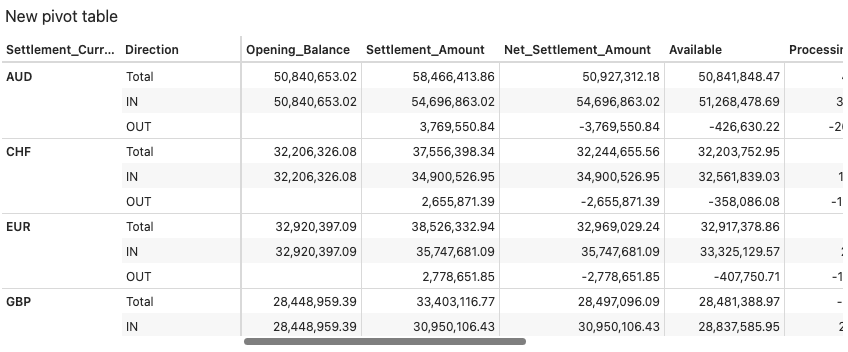

In [14]:
# Cashflows on 1st Oct 2021 for all currencies
session.widget

### 2.2 Gross payment

There are many ways we can get the gross payment received and sent. For instance, in the pivot table above, by querying the Direction level, we can see the total inflow and outflow amount.  
However, to put the two values side-by-side for comparison or further manipulation, we can create dedicated measures for each one using the [`filter`](https://docs.atoti.io/latest/lib/atoti/atoti.function.filter.html) function.  
Check out other [Atoti functions](https://docs.atoti.io/latest/lib/atoti/atoti.function.html). 

In [15]:
m["Gross payment received"] = tt.agg.sum(
    tt.filter(
        m["Settlement_Amount"],
        (l["Direction"] == "IN") & (~l["Status"].isin("Open posn", "Open party")),
    ),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)
m["Gross payment sent"] = tt.agg.sum(
    tt.filter(m["Settlement_Amount"], l["Direction"] == "OUT"),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
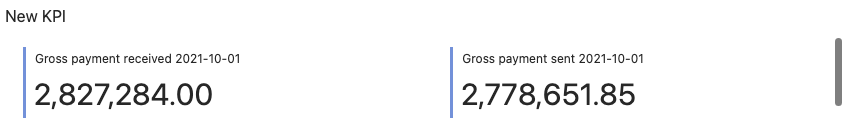

In [16]:
# Gross payment sent and received for EUR on 1st Oct 2021
session.widget

### 2.3 Net cumulative positions and Running balance

Both _Net cumulative positions_ and _Running balance_ are running total on the `Net_Settlement_Amount`. By making use of the [`CumulativeScope`](https://docs.atoti.io/latest/lib/atoti/atoti.scope.cumulative_scope.html) on the `Settlement_Time` level, we can accumulate the `Net_Settlement_Amount` along the `Settlement_Time` axis. This gives cumulative value accurate to the seconds. Check out on the available [Atoti scope](https://docs.atoti.io/latest/lib/atoti/atoti.scope.html) options.

The main difference between the two is that _Running balance_ is inclusive of the opening balance while _Net cumulative positions_ considers only the liquidity usage. For the intraday liquidity reporting, mostly we focus on the _Net cumulative positions_.

In [17]:
# excludes the opening balance
m["Net cumulative position"] = tt.agg.sum(
    tt.filter(m["Net_Settlement_Amount"], ~l["Status"].isin("Open posn", "Open party")),
    scope=tt.CumulativeScope(level=l["Settlement_Time"]),
)

m["Running balance"] = tt.agg.sum(
    m["Net_Settlement_Amount"], scope=tt.CumulativeScope(level=l["Settlement_Time"])
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
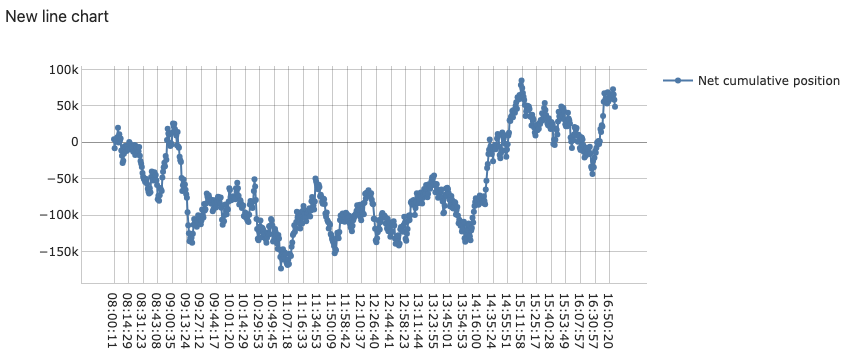

In [18]:
session.widget

### 2.4 Bucketing with Atoti

In this use case, we can perform bucketing by two hierarchies:
- Settlement Date
- Settlement Time 

#### 2.4.1 Date bucketing  

A common way to perform bucketing is to store the bucket values within the record. E.g. tokenize the `Settlement_Date` value into `Year`, `Month` and `Day`.

In Atoti, we can create the date hierarchy as shown below. Configure the required levels accordingly. Refer to the [Atoti documentation](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.create_date_hierarchy) for the date patterns that can be applied to the function.

In [19]:
cube.create_date_hierarchy(
    "Dates",
    column=payment_tbl["Settlement_Date"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM", "Day": "dd"},
)

We can easily drill down on each level to see the bucketed values.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
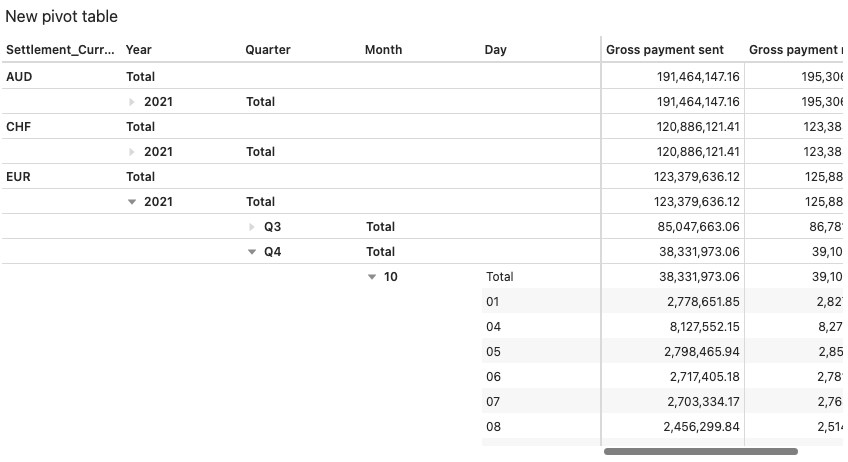

In [20]:
session.widget

#### 2.4.2 Time bucketing  

In this use case, we have stored the possible time buckets permutation in the Time table.  
We can create a multilevel `Time` hierarchy that stacks the `Hour`, `Minute` and `Second`.  

In [21]:
h["Time"] = [l["Hour"], l["Minute"], l["Second"]]

Previously, we created the measure `Net cumulative position` along the Cumulative scope of `Settlement_Time`, giving accuracy up to the seconds.  

Now that we have a multilevel time hierarchy, we can create another running total on the `Net_Settlement_Amount` along the lowest level, which is the `Second`.  

In [22]:
m["Cumulative position (ts)"] = tt.agg.sum(
    tt.filter(m["Net_Settlement_Amount"], ~l["Status"].isin("Open posn", "Open party")),
    scope=tt.CumulativeScope(level=l[("Time", "Time", "Second")]),
)

Do pay attention that we have to indicate the full path for level that is passed to the cumulative scope - `level=l[("Time", "Time", "Second")]`. That's because there are two paths to the level `Second`: 
- `l[("Time", "Second", "Second")`: the original single hierarchy `Second`
- `l[("Time", "Time", "Second")`: the newly created multilevel hierarchy.

We can now easily look at the liquidity usage at different intervals as shown in the GIF below:  

<img src="http://data.atoti.io/notebooks/intraday-liquidity/img/bucketed_cumulative_positions.gif" width="800px" />  

Try it out in the visualization below:

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
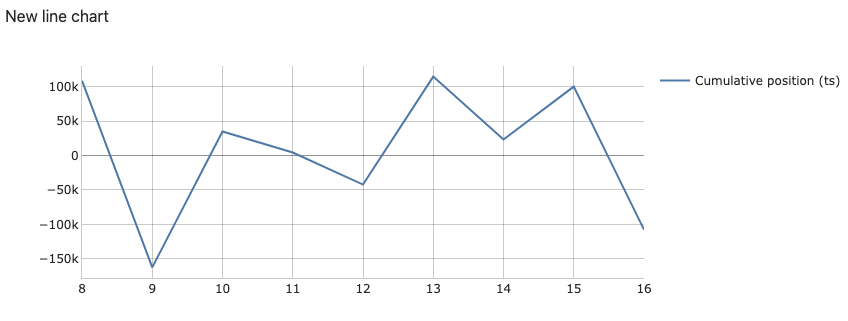

In [23]:
session.widget

### 2.5 Daily maximum and minimum cumulative position 

The below measures look at the maximum/minimum value at the `Settlement_Time` level.

In [24]:
m["_time_min"] = tt.agg.min(
    tt.where(~m["Settlement_Amount"].isnull(), m["Net cumulative position"]),
    scope=tt.SiblingsScope(hierarchy=h["Settlement_Time"], exclude_self=False),
)

m["_time_max"] = tt.agg.max(
    tt.where(~m["Settlement_Amount"].isnull(), m["Net cumulative position"]),
    scope=tt.SiblingsScope(hierarchy=h["Settlement_Time"], exclude_self=False),
)

m["_time_min_origin_scope"] = tt.agg.min(
    tt.where(~m["Settlement_Amount"].isnull(), m["Net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Time"]}),
)

Using sibling scope, we compare the values within a given level. Hence the values will be constant across all the `Settlement_Time`.  
Below table shows the difference in behavior from `OriginScope` and `SiblingScope` on the maximum and minimum aggregation function. 
Check out the [Atoti scopes](https://docs.atoti.io/latest/lib/atoti/atoti.scope.html). 

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
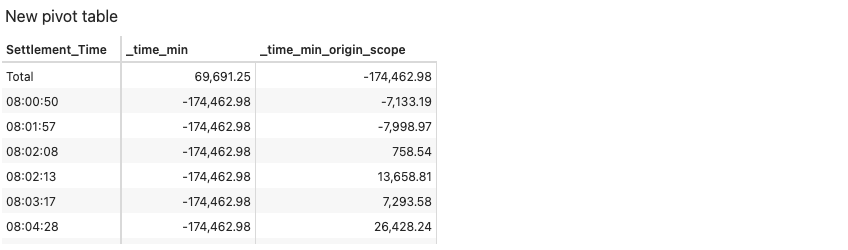

In [25]:
# Difference between OriginScope and SiblingScope
session.widget

Using `_time_max` and `_time_min`, we can see which are the timings where the cumulative balance is close to the peaks.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
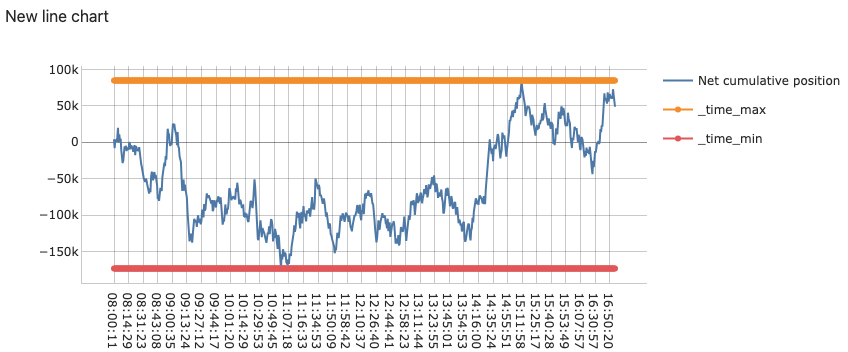

In [26]:
# Daily maximum liquidity usage for EUR on 1st Oct 2021
session.widget

Alternatively, we can make use of the measures `_time_max` and `_time_min` to compute keep only the largest positive and negative net cumulative positions across the `Settlement_Date` at the time of occurrence.  

To do so, we applied a conditional check such that the value is only returned if the largest value is the same as the `Net cumulative position` value (i.e. only 1 point is returned for each measure). 

In [27]:
m["Largest +ve net cumulative position"] = tt.agg.max(
    tt.where(m["Net cumulative position"] == m["_time_max"], m["_time_max"]),
    scope=tt.OriginScope({l["Settlement_Time"], l["Settlement_Date"]}),
)

m["Largest -ve net cumulative position"] = tt.agg.min(
    tt.where(m["Net cumulative position"] == m["_time_min"], m["_time_min"]),
    scope=tt.OriginScope({l["Settlement_Time"], l["Settlement_Date"]}),
)

So, we can now highlight the highest and lowest point in the curve in the visual below. 

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
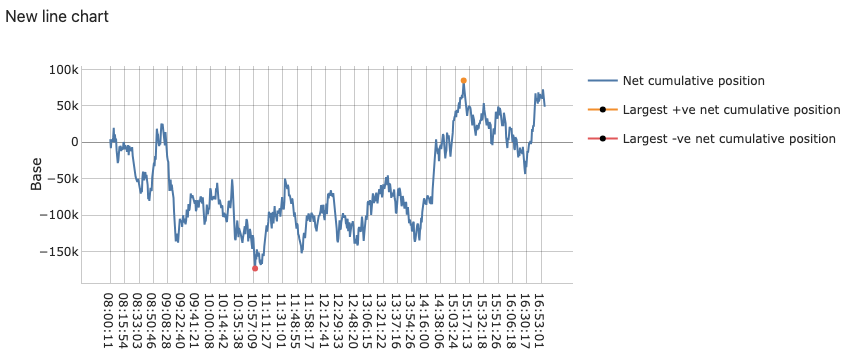

In [28]:
# Daily maximum liquidity usage for EUR on 1st Oct 2021
session.widget

Since the measure `_time_min_origin_scope` is only used to showcase the different use of scope, we will delete it to avoid cluttering of the measures.

In [29]:
del m["_time_min_origin_scope"]

### 2.6 Intraday throughput

Intraday throughput looks at the total payment sent across the day. Therefore, let's exclude the opening balance and look at the `Settlement_Amount` for the out flow.

In [30]:
m["Intraday throughput"] = tt.agg.sum(
    tt.filter(
        m["Settlement_Amount"],
        (~l["Status"].isin("Open posn", "Open party")) & (l["Direction"] == "OUT"),
    ),
    scope=tt.CumulativeScope(level=l[("Time", "Time", "Minute")]),
)

Once we get the running total of the outgoing cashflows, we use [`atoti.total` function](https://docs.atoti.io/latest/lib/atoti/atoti.function.total.html#) to get the total value of the throughput across the time bucket.  
This will allow us to get the `% sent` value as specified in [BCBS248](https://www.bis.org/publ/bcbs248.pdf).

In [31]:
m["_parent_total"] = tt.total(m["Intraday throughput"], h["Time"])
m["% sent"] = m["Intraday throughput"] / m["_parent_total"]
m["% sent"].formatter = "DOUBLE[#.00%]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
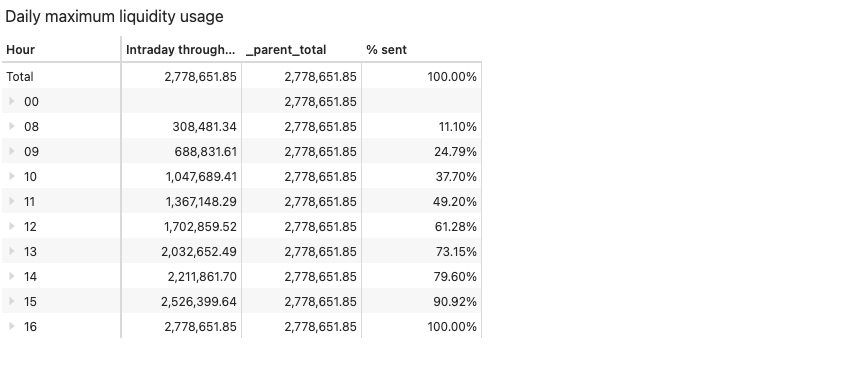

In [32]:
# Daily maximum liquidity usage
session.widget

Again, the `_parent_total` measure is just a technical measure. So let's hide it.

In [33]:
m["_parent_total"].visible = False

## 3 Reporting measures

Based on the sample report mentioned in [BCBS248](https://www.bis.org/publ/bcbs248.pdf), a bulk of it involves the top and bottom 3 positions on various type of cashflows .  
Below is a simple demonstration to show how we can obtain the top 3 largest positive and negative net cumulative positions for each month.

#### 3.1 Ranking the measures

We [rank](https://docs.atoti.io/latest/lib/atoti/atoti.function.rank.html) the `largest +ve net cumulative position` of the `Settlement_Date` in descending order while the `largest -ve net cumulative position` in ascending order so that we can get the maximum and minimum values ranked at the top.

In [34]:
m["Daily max ranking"] = tt.rank(
    m["Largest +ve net cumulative position"], h["Settlement_Date"], ascending=False
)
m["Daily min ranking"] = tt.rank(
    m["Largest -ve net cumulative position"], h["Settlement_Date"]
)

#### 3.2 Creating measures for 1st, 2nd and 3rd in period

Again, we could use filters in the Atoti content editor to interactive filter the results to show only the top 3 positions.  
However, for reporting purpose, it is easier to create a measure for each of these, using the `filter` function programmatically.  

In [35]:
m["Max in period"] = tt.agg.single_value(
    tt.where(m["Daily max ranking"] == 1, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)
m["2nd max in period"] = tt.agg.single_value(
    tt.where(m["Daily max ranking"] == 2, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)
m["3rd max in period"] = tt.agg.single_value(
    tt.where(m["Daily max ranking"] == 3, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)

In [36]:
m["Min in period"] = tt.agg.single_value(
    tt.where(m["Daily min ranking"] == 1, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)
m["2nd min in period"] = tt.agg.single_value(
    tt.where(m["Daily min ranking"] == 2, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)
m["3rd min in period"] = tt.agg.single_value(
    tt.where(m["Daily min ranking"] == 3, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope({l["Settlement_Date"]}),
)

#### 3.3 Average max over period

To get the average max over period, simply apply the `atoti.agg.mean` function over the `largest +ve net cumulative position`.  
Repeat the same thing for the minimum value, using the `largest -ve net cumulative position` instead.

In [37]:
m["Average max over period"] = tt.agg.mean(
    m["Largest +ve net cumulative position"],
    scope=tt.OriginScope({l["Settlement_Date"]}),
)

m["Average min over period"] = tt.agg.mean(
    m["Largest -ve net cumulative position"],
    scope=tt.OriginScope({l["Settlement_Date"]}),
)

The below visualization shows how easily we can expand each currency to see when the max value occurred.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
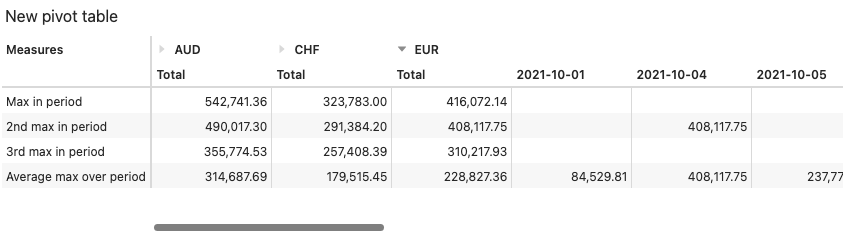

In [38]:
# Largest positive net cumulative position
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
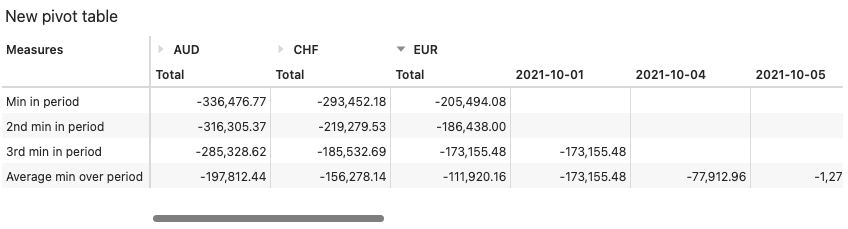

In [39]:
# Largest negative net cumulative position
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
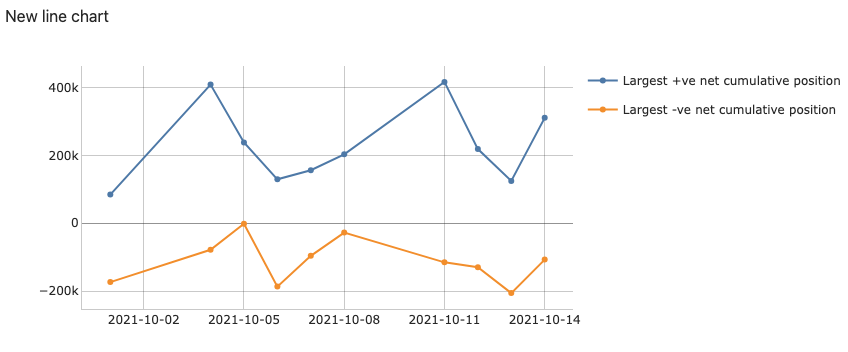

In [40]:
# Largest +ve/-ve net cumulative position trend for October 2021
session.widget

#### 3.4 Organize the measures 

Instead of having the measures ordered alphabetically in a long list, we can organize them in folders for easier access:

In [41]:
for measure in [
    m["Largest +ve net cumulative position"],
    m["Daily max ranking"],
    m["Max in period"],
    m["2nd max in period"],
    m["3rd max in period"],
    m["Average max over period"],
]:
    measure.folder = "Max"

for measure in [
    m["Largest -ve net cumulative position"],
    m["Daily min ranking"],
    m["Min in period"],
    m["2nd min in period"],
    m["3rd min in period"],
    m["Average min over period"],
]:
    measure.folder = "Min"

## 4 Creating dashboard

We can easily export the visuals above and put together a dashboard as shown in the GIF below:

<img src="http://data.atoti.io/notebooks/intraday-liquidity/img/dashboard_building.gif" width="800px" />

Check out this dashboard which we prepared beforehand!

In [42]:
session.link / "#/dashboard/1b7"

http://localhost:10012/#/dashboard/1b7

## 5 Stress testing (what-if analysis)

Simulations are a way to compare several scenarios and do what-if analysis. This helps us understand how changing the source data or a piece of the model impacts key indicators. For this use case, we can perform a source simulation in which we simulate 1 hour late payments received for the counterparty `Commerzbank`.

In [43]:
payment_df = pd.read_parquet(
    "s3://data.atoti.io/notebooks/intraday-liquidity/data/cashflow_202110_counterparty.parquet"
)


def shift_date_time_by_hour(x):
    late_payment_df = payment_df[payment_df["Counterparty"] == "Commerzbank"].copy()

    # Format as datetime and push incoming payments received by x hrs (excluding opening balance)
    late_payment_df["Settlement_Time"] = pd.to_datetime(
        late_payment_df["Settlement_Time"], format="%H:%M:%S"
    )
    late_payment_df.loc[
        (late_payment_df["Direction"] == "IN")
        & (~late_payment_df["Status"].isin(["Open posn", "Open party"])),
        "Settlement_Time",
    ] += pd.Timedelta(hours=x)

    # Take time value only and set back to string for loading into Atoti table
    late_payment_df["Settlement_Time"] = late_payment_df["Settlement_Time"].dt.time
    late_payment_df["Settlement_Time"] = late_payment_df["Settlement_Time"].astype(str)
    payment_tbl.scenarios[f"{x} hour late payments received"].load(late_payment_df)


for i in range(1, 4):
    shift_date_time_by_hour(i)

We see the impacts of 1, 2, and 3 hour late payments received when we compare the simulations to the `Base` scenario by tracking the running balance with consideration to payments received vs. payments sent.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
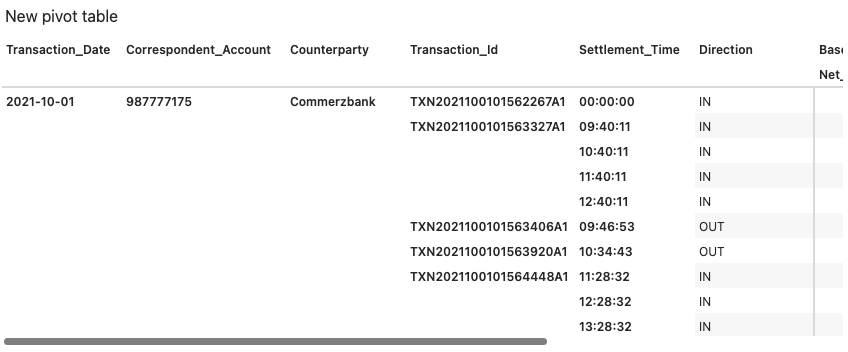

In [44]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
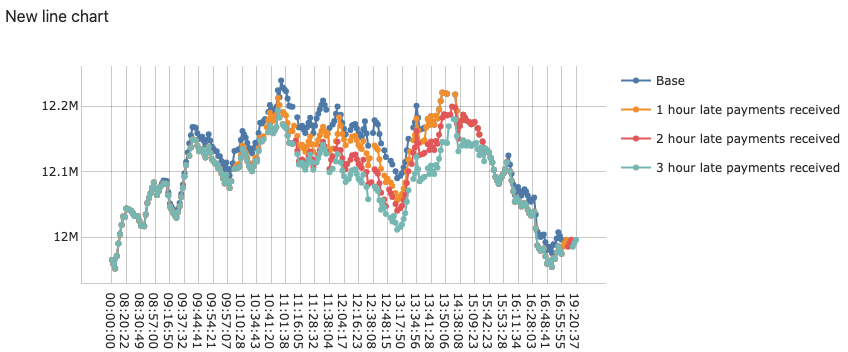

In [45]:
session.widget

Alternatively, we can track the _Net cumulative positions_ to consider the impacts on liquidity usage for the additional scenarios.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
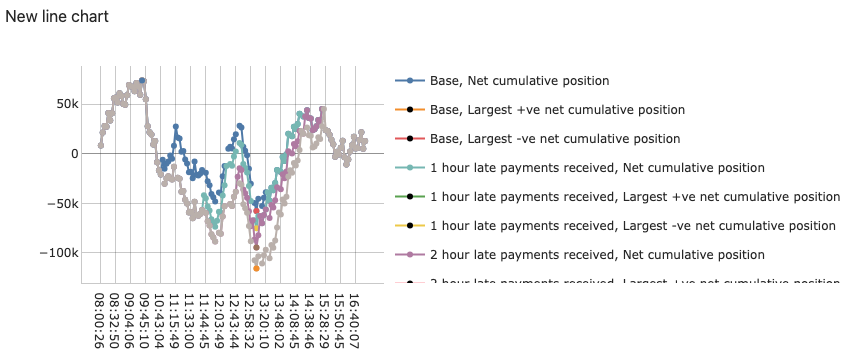

In [46]:
session.widget

## 6 Intraday real-time monitoring

We have prepared some cashflow transactions for 15th Oct 2021. Before you continue with the below sections, open up the dashboard below and ensure that the quick filter is on the correct settlement date.

In [47]:
session.link / "#/dashboard/1fc"

http://localhost:10012/#/dashboard/1fc

Let's simulate some real-time cashflows.

In [48]:
# Keep the minimum balance in order to keep the breach in case the running balance moves back up
m["Running balance Min"] = tt.agg.min(
    m["Running balance"], scope=tt.OriginScope({l["Settlement_Time"]})
)

m["Running balance Max"] = tt.agg.max(
    m["Running balance"], scope=tt.OriginScope({l["Settlement_Time"]})
)

In [49]:
# Create some limits
m["Running balance Min KPI Status"] = tt.where(
    m["Running balance Min"] < 1330000, "❌", "✅"
)
m["Running balance KPI Status"] = tt.where(m["Running balance"] < 1330000, "❌", "✅")

In [50]:
rt_chunks_df = pd.read_csv(
    "s3://data.atoti.io/notebooks/intraday-liquidity/data/cashflow_realtime_20211015_counterparty.csv",
    chunksize=50,
    parse_dates=["Transaction_Date", "Settlement_Date"],
)

In [ ]:
# Columns to exclude
columns_to_exclude = [
    "Settlement_Date_auto_yyyy",
    "Settlement_Date_auto_QQQ",
    "Settlement_Date_auto_MM",
    "Settlement_Date_auto_dd",
]

# Determine final list of clumns to load (those in payment_tbl minus excluded columns)
columns_to_load = [col for col in payment_tbl if col not in columns_to_exclude]

for chunk in rt_chunks_df:
    t = chunk.reset_index()
    # loads only the relevant columns
    # https://github.com/atoti/atoti/issues/758
    payment_tbl.load(t[columns_to_load])
    print(".", end="")
    time.sleep(1)
print("End")

.......................

Check out how responsive the dashboard is, loading 50 records at 1s throttled speed:

<img src="http://data.atoti.io/notebooks/intraday-liquidity/img/realtime_cashflow_monitoring.gif" width="850px" />

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=intraday_liquidity" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>